### Tanzinian Water Pump Classification ###

### Model Evaluation


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import optuna

from sklearn.linear_model import Lasso, Ridge, LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, SCORERS, balanced_accuracy_score, plot_confusion_matrix, classification_report
plt.style.use('ggplot')

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

### Read in Testing and Training Data From Cleaning and EDA


In [59]:
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/y_train.pkl')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

### Get Dummies for Catergorical Variables

In [61]:
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [62]:
[x for x in X_train.columns if x not in X_test.columns]

[]

In [63]:
[x for x in X_test.columns if x not in X_train.columns]

[]

### Scale and resample the data
#### Made X_train and X_test simple variables. 


In [64]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train_ohe)
X_test = scale.transform(X_test_ohe)

In [65]:
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train) 

### Gradient Descent Warm Start


### LogReg with Lasso 

In [89]:
LogRegLasso = LogisticRegression(penalty = 'l1', 
                                 tol = 0.0001, 
                                 C = 1, 
                                 solver='liblinear', 
                                 class_weight = 'balanced', 
                                 max_iter = 300)

In [90]:
LogRegLasso.fit(X_train, y_train)
y_pred_lasso = LogRegLasso.predict(X_test)

In [91]:
print('F1: ', f1_score(y_test, y_pred_lasso, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_lasso))

F1:  0.6950883111100785
Accuracy:  0.6796766163792803


In [93]:
print(classification_report(y_test, y_pred_lasso))

                         precision    recall  f1-score   support

             functional       0.82      0.65      0.73      4822
functional needs repair       0.23      0.71      0.35       678
         non functional       0.77      0.68      0.72      3410

               accuracy                           0.67      8910
              macro avg       0.61      0.68      0.60      8910
           weighted avg       0.76      0.67      0.70      8910



In [94]:
mod = open('PKL/LogRegLasso.pkl', 'wb')
pickle.dump(LogRegLasso, mod)
mod.close()

In [96]:
LogRegLasso.summary()

AttributeError: 'LogisticRegression' object has no attribute 'summary'

### Logistic Regression

In [95]:
LogReg = LogisticRegression(solver='liblinear',
                            class_weight = 'balanced', 
                            max_iter = 200)

LogReg.fit(X_train, y_train)
y_pred_logreg = LogReg.predict(X_test)

print('F1: ', f1_score(y_test, y_pred_logreg, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_logreg))

F1:  0.6947864442358115
Accuracy:  0.6794692335505785


In [ ]:
print(classification_report(y_test, y_pred_logreg))

In [ ]:
LogReg.summary()

In [ ]:
mod = open('PKL/LogReg.pkl', 'wb')
pickle.dump(LogReg, mod)
mod.close()

### KNN 
First I will start with a simple KNN. 
Then we will use Optuna to run and attempt to find the best model. 

### Simple KNN

In [9]:
knnSimple = KNeighborsClassifier(n_neighbors = 5, 
                                 p = 2, 
                                 n_jobs = -1)

In [10]:
knnSimple.fit(X_train, y_train)
y_pred_knnSimple = knnSimple.predict(X_test)

In [11]:
print('F1: ', f1_score(y_test, y_pred_knnSimple, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_knnSimple))

F1:  0.71711628105347
Accuracy:  0.6562379215275892


In [33]:
print(classification_report(y_test, y_pred_knnSimple))

                         precision    recall  f1-score   support

             functional       0.81      0.72      0.76      4822
functional needs repair       0.28      0.54      0.37       678
         non functional       0.74      0.71      0.73      3410

               accuracy                           0.70      8910
              macro avg       0.61      0.66      0.62      8910
           weighted avg       0.74      0.70      0.72      8910



Save Knn Model

In [12]:
mod = open('PKL/knnSimple.pkl', 'wb')
pickle.dump(knnSimple, mod)
mod.close()

### Running KNN with Optuna

In [516]:
def knn_objective(trial): 
    knn_neighbors = trial.suggest_int('n_neighbors', 1,10) 
    knn_p = trial.suggest_categorical('p', [1, 2])
    knn_leaf_size = trial.suggest_int('leaf_size', 2, 50)
    knn_algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    
    knn = KNeighborsClassifier(n_neighbors = knn_neighbors, 
                               p = knn_p, 
                               leaf_size = knn_leaf_size,
                                algorithm =  knn_algorithm)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    
    knn.fit(X_train, y_train)
    y_pred_optuna = knn.predict(X_test)
    return (1 - f1_score(y_test, y_pred_optuna, average = 'weighted'))

In [ ]:
study = optuna.create_study()

In [ ]:
study.optimize(knn_objective, n_trials = 100)

[I 2020-08-20 08:10:02,743] Trial 0 finished with value: 0.2525007574872148 and parameters: {'n_neighbors': 6, 'p': 1, 'leaf_size': 38, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.2525007574872148.
[I 2020-08-20 08:29:52,961] Trial 1 finished with value: 0.26217077385548193 and parameters: {'n_neighbors': 10, 'p': 1, 'leaf_size': 18, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.2525007574872148.
[I 2020-08-20 09:02:01,508] Trial 2 finished with value: 0.24328000217342982 and parameters: {'n_neighbors': 2, 'p': 1, 'leaf_size': 6, 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.24328000217342982.
[I 2020-08-20 09:14:35,998] Trial 3 finished with value: 0.2640357918244377 and parameters: {'n_neighbors': 9, 'p': 1, 'leaf_size': 30, 'algorithm': 'kd_tree'}. Best is trial 2 with value: 0.24328000217342982.
[I 2020-08-20 09:19:49,937] Trial 4 finished with value: 0.2736111234120412 and parameters: {'n_neighbors': 5, 'p': 2, 'leaf_size': 50, 'algorithm': 'kd_tre

In [39]:
#Best is trial 2 of 6 with value: 0.24328000217342982

knnOptuna = KNeighborsClassifier(n_neighbors = 2, 
                                 p = 1, 
                                 leaf_size = 6, 
                                 algorithm = 'kd_tree', 
                                 n_jobs = -1)
knnOptuna.fit(X_train, y_train)
y_pred_knnOptuna = knnOptuna.predict(X_test)
print('F1: ', f1_score(y_test, y_pred_knnOptuna, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_knnOptuna))

F1:  0.7419922123377675
Accuracy:  0.6245697927096333


In [41]:
print(classification_report(y_test, y_pred_knnOptuna))

                         precision    recall  f1-score   support

             functional       0.75      0.88      0.81      4822
functional needs repair       0.37      0.36      0.36       678
         non functional       0.84      0.64      0.72      3410

               accuracy                           0.75      8910
              macro avg       0.65      0.62      0.63      8910
           weighted avg       0.75      0.75      0.74      8910



In [40]:
mod = open('PKL/knnOptuna.pkl', 'wb')
pickle.dump(knnOptuna, mod)
mod.close()

In [50]:
knnOptuna2 = KNeighborsClassifier(n_neighbors = 2, 
                                 p = 1, 
                                 leaf_size = 17, 
                                 algorithm = 'kd_tree', 
                                 n_jobs = -1)
knnOptuna2.fit(X_train, y_train)
y_pred_knnOptuna2 = knnOptuna2.predict(X_test)
print('F1: ', f1_score(y_test, y_pred_knnOptuna2, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_knnOptuna2))

F1:  0.7419922123377675
Accuracy:  0.6245697927096333


In [51]:
print(classification_report(y_test, y_pred_knnOptuna2))

                         precision    recall  f1-score   support

             functional       0.75      0.88      0.81      4822
functional needs repair       0.37      0.36      0.36       678
         non functional       0.84      0.64      0.72      3410

               accuracy                           0.75      8910
              macro avg       0.65      0.62      0.63      8910
           weighted avg       0.75      0.75      0.74      8910



### Simple Decision Tree

#### Starting with a few simple decision trees, then expant to Optuna to find a better model. 

In [16]:
dtcSimple = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, random_state = 1, class_weight = 'balanced')

In [17]:
dtcSimple.fit(X_train, y_train)
y_pred_dtcSimple = dtcSimple.predict(X_test)

In [18]:
print('F1: ', f1_score(y_test, y_pred_dtcSimple, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_dtcSimple))

F1:  0.7284391075730546
Accuracy:  0.642285014506644


In [34]:
print(classification_report(y_test, y_pred_dtcSimple))

                         precision    recall  f1-score   support

             functional       0.78      0.77      0.77      4822
functional needs repair       0.30      0.45      0.36       678
         non functional       0.77      0.71      0.74      3410

               accuracy                           0.72      8910
              macro avg       0.62      0.64      0.62      8910
           weighted avg       0.74      0.72      0.73      8910



In [19]:
mod = open('PKL/dtcSimple.pkl', 'wb')
pickle.dump(dtcSimple, mod)
mod.close()

### Decision Tree with Optuna

In [494]:
def dtc_objective(trial): 
    dtc_criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    dtc_splitter = trial.suggest_categorical('n_neighbors', ['best', 'random']) 
    dtc_maxdepth = trial.sugguest_int('max_depth', 1,10)
    dtc_maxfeatures = trial.suggest_int('max_features', .01, .7)
    
    dtc = DecisionTreeClassifier(criterion = dtc_criterion, 
                                 splitter = dtc_splitter, 
                                 max_depth = dtc_maxdepth, 
                                 max_features = dtc_maxfeatures, 
                                class_weight = 'balanced')
    
    dtc.fit(X_train, y_train)
    y_pred_dtc= dtc.predict(X_test)
    return (1 - f1_score(y_test, y_pred_dtc, average = 'weighted'))

In [ ]:
study = optuna.create_study()

In [ ]:
study.optimize(dtc_objective, n_trials = 100)

In [75]:
dtcOptuna = DecisionTreeClassifier(criterion = 'gini', 
                                 splitter = 'random', 
                                 max_depth = 10, 
                                 max_features = 'sqrt', 
                                class_weight = 'balanced')


In [76]:
dtcOptuna.fit(X_train, y_train)
y_pred_dtcOptuna = dtcOptuna.predict(X_test)

In [77]:
print('F1: ', f1_score(y_test, y_pred_dtcOptuna, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_dtcOptuna))

F1:  0.6032149770407131
Accuracy:  0.5466137640214893


In [79]:
print(classification_report(y_test, y_pred_dtcOptuna))

                         precision    recall  f1-score   support

             functional       0.71      0.63      0.66      4822
functional needs repair       0.19      0.47      0.27       678
         non functional       0.63      0.54      0.58      3410

               accuracy                           0.58      8910
              macro avg       0.51      0.55      0.51      8910
           weighted avg       0.64      0.58      0.60      8910



In [83]:
mod = open('PKL/dtcOptuna.pkl', 'wb')
pickle.dump(dtcOptuna, mod)
mod.close()

### Random Forest

#### Random forest classifer, then expanded to test optuna. 

In [20]:
rfcSimple = RandomForestClassifier(random_state = 1, 
                                   n_estimators = 500, 
                                   max_depth = 3, 
                                   max_features = .3, 
                                   class_weight = 'balanced_subsample', 
                                   criterion = 'gini')

In [21]:
rfcSimple.fit(X_train, y_train)
y_pred_rfcSimple = rfcSimple.predict(X_test)

In [22]:
print('F1: ', f1_score(y_test, y_pred_rfcSimple, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_rfcSimple))

F1:  0.6463530464336945
Accuracy:  0.5665821264567874


In [35]:
print(classification_report(y_test, y_pred_rfcSimple))

                         precision    recall  f1-score   support

             functional       0.69      0.79      0.74      4822
functional needs repair       0.19      0.46      0.27       678
         non functional       0.86      0.45      0.59      3410

               accuracy                           0.63      8910
              macro avg       0.58      0.57      0.53      8910
           weighted avg       0.72      0.63      0.65      8910



In [23]:
mod = open('PKL/rfcSimple.pkl', 'wb')
pickle.dump(rfcSimple, mod)
mod.close()

### Random Forest with Optuna

In [20]:
def objective(trial): 
    rfc_max_depth = trial.suggest_int('max_depth', 5,10)
    rfc_n_estimators = trial.suggest_int('n_estimators', 300, 700) 
    rfc_max_features = trial.suggest_loguniform('max_features', .001, .2)
    rfc_criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    rfc = RandomForestClassifier(random_state = 1, max_depth = rfc_max_depth, n_estimators = rfc_n_estimators,
                                 max_features = rfc_max_features, criterion = rfc_criterion, class_weight = 'balanced')
    rfc.fit(X_train, y_train)
    y_pred_optuna = rfc.predict(X_test)
    return (1 - f1_score(y_test, y_pred_optuna, average = 'weighted'))

In [21]:
study = optuna.create_study()

In [ ]:
study.optimize(objective, n_trials = 100)

#### rfc Optuna

In [24]:
rfc_Optuna = RandomForestClassifier(random_state = 1, 
                                    n_estimators = 572, 
                                    max_depth = 10, 
                                   max_features = 0.06602383170294993, 
                                    class_weight = 'balanced', 
                                    criterion = 'gini')
rfc_Optuna.fit(X_train, y_train)
y_pred_Optuna = rfc_Optuna.predict(X_test)
print('F1: ', f1_score(y_test, y_pred_Optuna, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_Optuna))

F1:  0.733414442080737
Accuracy:  0.6809539623754565


In [37]:
print(classification_report(y_test, y_pred_Optuna))

                         precision    recall  f1-score   support

             functional       0.79      0.78      0.78      4822
functional needs repair       0.28      0.62      0.38       678
         non functional       0.84      0.65      0.73      3410

               accuracy                           0.72      8910
              macro avg       0.64      0.68      0.63      8910
           weighted avg       0.77      0.72      0.73      8910



In [25]:
mod = open('PKL/rfc_Optuna.pkl', 'wb')
pickle.dump(rfc_Optuna, mod)
mod.close()

#### rfc Optuna 2

In [80]:
rfc_Optuna2 = RandomForestClassifier(random_state = 1, 
                                     n_estimators = 362, 
                                     max_depth = 10, 
                                     max_features = 0.0554940476012136275, 
                                     class_weight = 'balanced', 
                                     criterion = 'gini')

rfc_Optuna2.fit(X_train, y_train)
y_pred_Optuna2 = rfc_Optuna2.predict(X_test)

print('F1: ', f1_score(y_test, y_pred_Optuna2, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_Optuna2))

F1:  0.7321537448880838
Accuracy:  0.6811399686813578


In [84]:
print(classification_report(y_test, y_pred_Optuna2))

                         precision    recall  f1-score   support

             functional       0.79      0.76      0.78      4822
functional needs repair       0.28      0.61      0.38       678
         non functional       0.82      0.67      0.74      3410

               accuracy                           0.72      8910
              macro avg       0.63      0.68      0.63      8910
           weighted avg       0.77      0.72      0.73      8910



In [85]:
mod = open('PKL/rfc_Optuna2.pkl', 'wb')
pickle.dump(rfc_Optuna2, mod)
mod.close()

### Plotting Feature Importances

In [86]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(14,100))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

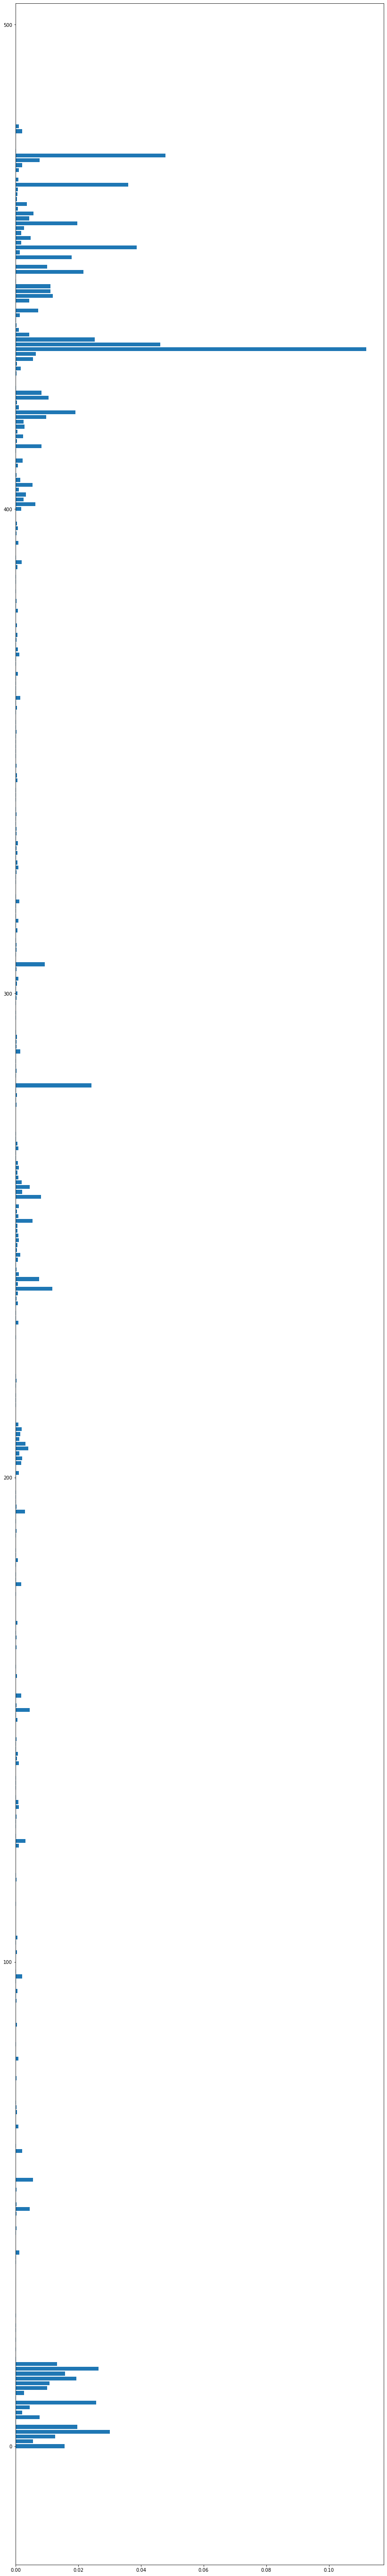

In [88]:
plot_feature_importances(rfc_Optuna2)

### GridSearchCV 

In [ ]:
                                      ('rfc_Optuna2', rfc_Optuna2), 

### Voting Classifer

In [45]:
vote = VotingClassifier( estimators= [('knn', knnSimple),
                                      ('knnOptuna', knnOptuna),
                                      ('dtcSimple', dtcSimple),
                                      ('rfc_Optuna', rfc_Optuna)], 
                                        voting='hard')

vote.fit(X_train, y_train)
y_pred_vote = vote.predict(X_test)

print('F1: ', f1_score(y_test, y_pred_vote, average = 'weighted'))
print('Accuracy: ', balanced_accuracy_score(y_test, y_pred_vote))

F1:  0.7567368623240992
Accuracy:  0.6557936244912733


In [46]:
print(classification_report(y_test, y_pred_vote))

                         precision    recall  f1-score   support

             functional       0.77      0.88      0.82      4822
functional needs repair       0.35      0.45      0.39       678
         non functional       0.88      0.64      0.74      3410

               accuracy                           0.76      8910
              macro avg       0.66      0.66      0.65      8910
           weighted avg       0.78      0.76      0.76      8910



In [47]:
mod = open('PKL/vote.pkl', 'wb')
pickle.dump(vote, mod)
mod.close()